In [63]:
import torch

In [96]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [78]:
N = torch.zeros((27, 27, 27), dtype=torch.float32)

In [66]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [79]:
for w in words:
	chs = ['.'] + ['.'] + list(w) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		# pair = pair[0] + pair[1]
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]
		N[ix1, ix2, ix3] += 1
	

In [68]:
N[stoi['.'], stoi['e'], stoi['m']]

tensor(288.)

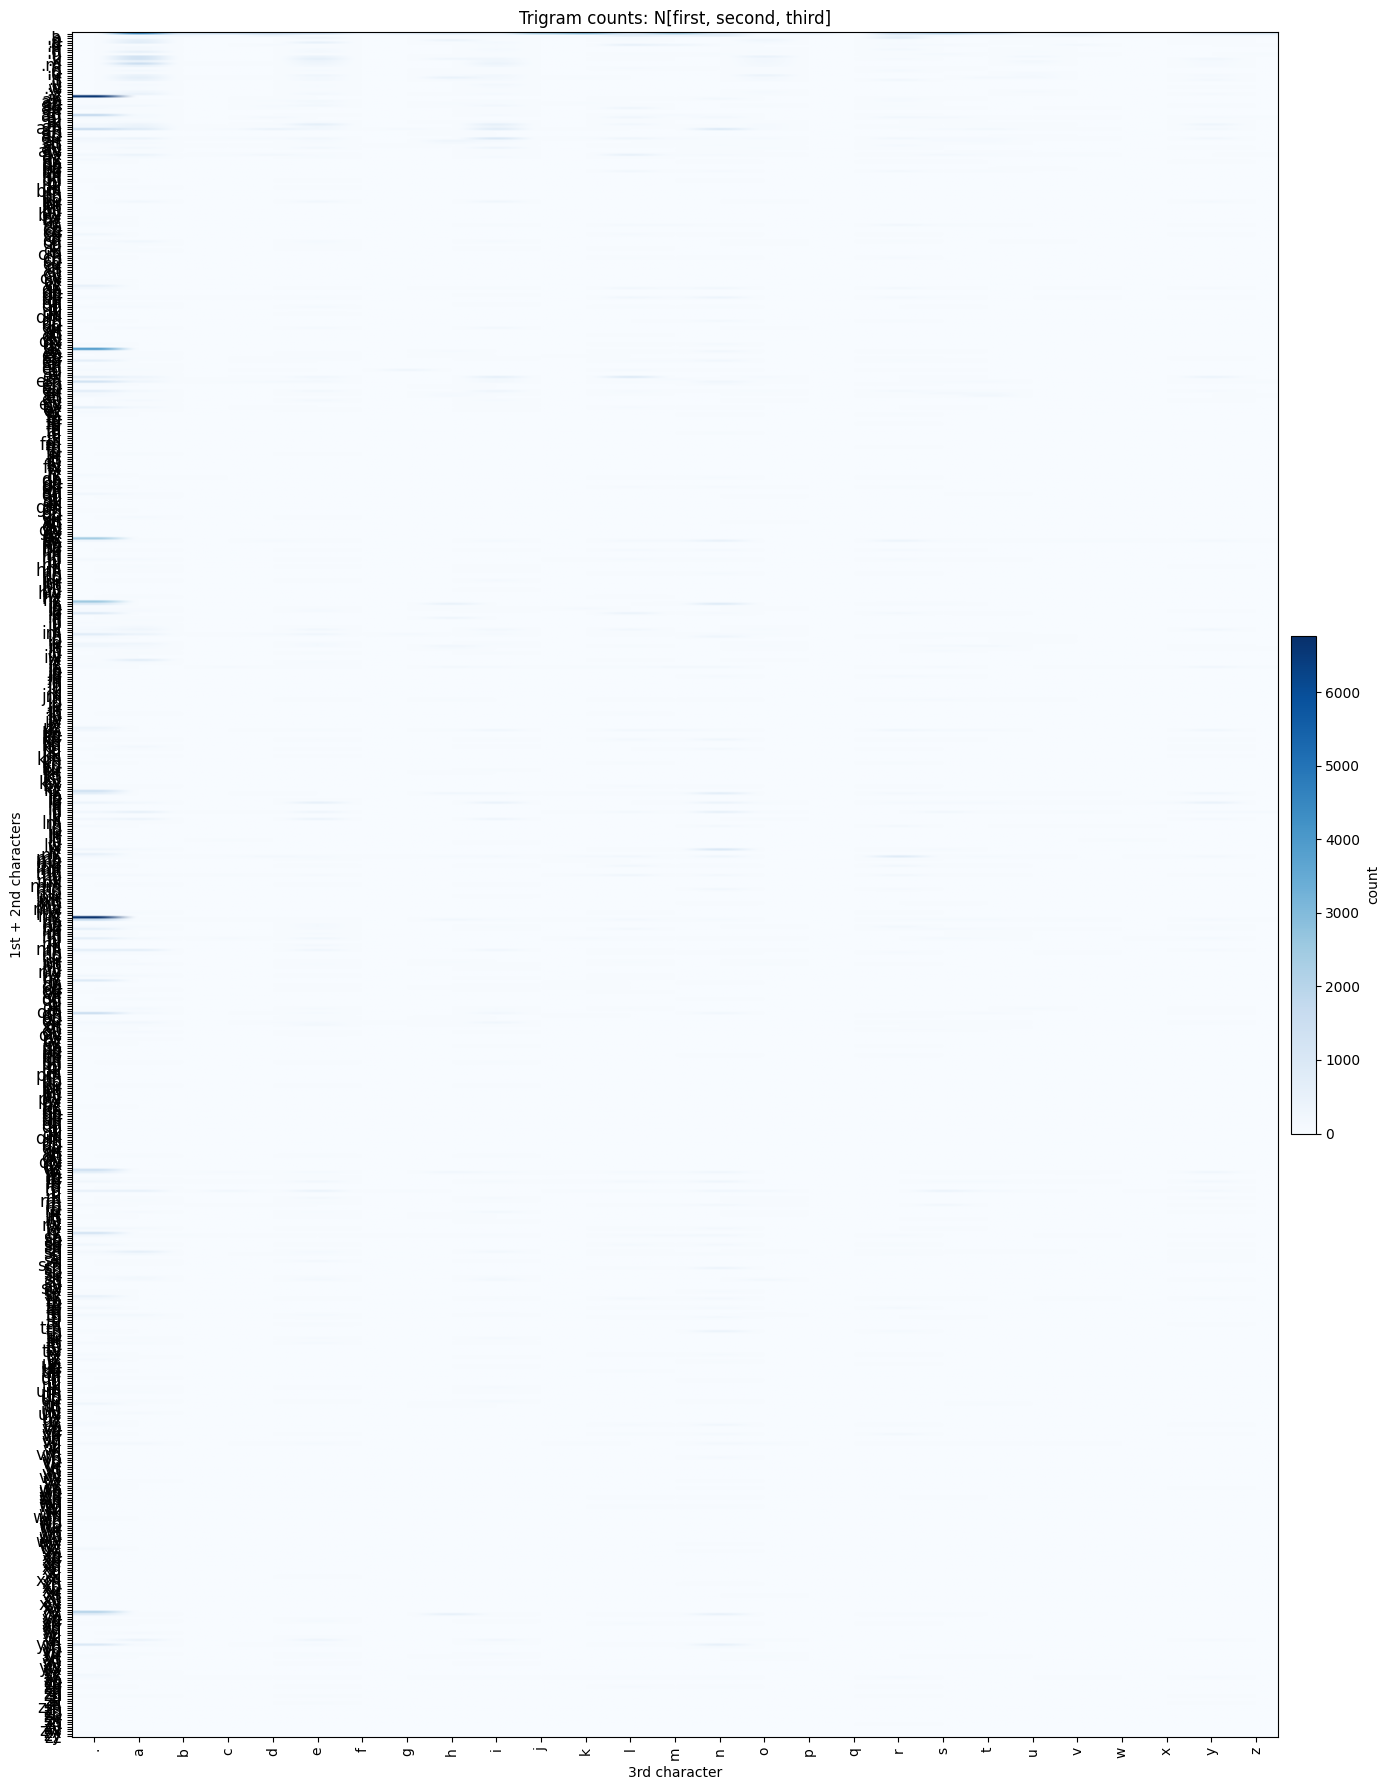

In [69]:
import numpy as np

# build a 729 x 27 matrix -------------------------------------------------
M = N.reshape(27*27, 27)          # (729, 27)  – torch tensor
M_np = M.detach().cpu().numpy()                 # matplotlib wants a NumPy array

# labels for the axes -----------------------------------------------------
row_labels = [itos[i] + itos[j]          # ‘aa’, ‘ab’, … , ‘zz’
              for i in range(27)         # 0..26
              for j in range(27)]
col_labels = [itos[k] for k in range(27)]   # ‘.’, ‘a’, … , ‘z’

# -------------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 18))
im = plt.imshow(M_np, cmap='Blues', aspect='auto')

# tidy axis ticks & labels
plt.xticks(range(27), col_labels, rotation=90)
plt.yticks(range(27*27), row_labels, fontsize=12)   # 729 ticks – small font
plt.xlabel('3rd character')
plt.ylabel('1st + 2nd characters')
plt.colorbar(im, fraction=0.02, pad=0.01, label='count')
plt.title('Trigram counts: N[first, second, third]')

plt.tight_layout()
plt.show()

In [70]:
N[0, 0]

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])

In [80]:
P = (N+1).float()
P /= P.sum(2, keepdim=True)

In [72]:
P[0, 2].sum()

tensor(1.0000)

In [85]:
g = torch.Generator().manual_seed(2147483647+2)

for i in range(10):
	out = []
	ix1, ix2 = 0, 0

	while(True):
		p = P[ix1, ix2]
		# ix1 = ix2
		ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		out.append(itos[ix3])

		if ix3 == 0:
			break

		ix1, ix2 = ix2, ix3

	print(''.join(out))

taylor.
keigelielillagaurjraidalana.
marqoken.
lonniah.
zamdennet.
artymaya.
que.
kenna.
mond.
jaarnishilleschamilynneifen.


In [91]:
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["andrejq"]:
	chs = ['.'] + ['.'] + list(w) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		prob = P[ix1, ix2, ix3]
		log_prob = torch.log(prob)
		log_likelihood += log_prob
		n += 1
		# print(f'{pair} {ch}: {prob:.4f} {log_prob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-504653.)
nll=tensor(504653.)
2.2119739055633545


### now with neurons and stuff

In [105]:
x1s, x2s, ys = [], [], []

for word in words[:1]:
	chs = ['.'] + ['.'] + list(word) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		x1s.append(ix1)
		x2s.append(ix2)
		ys.append(ix3)

x1s = torch.tensor(x1s)
x2s = torch.tensor(x2s)
ys = torch.tensor(ys)

In [106]:
x1s

tensor([ 0,  0,  5, 13, 13])

In [104]:
ys

tensor([ 5, 13, 13,  1,  0])

In [108]:
import torch.nn.functional as F

xenc = torch.cat([F.one_hot(x1s, num_classes=27),
				 F.one_hot(x2s, num_classes=27)], dim=1).float()

xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0.,

In [110]:
xenc.shape

torch.Size([5, 54])

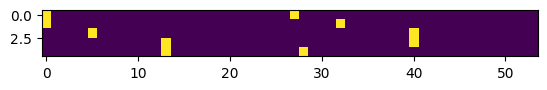

In [112]:
plt.imshow(xenc)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)

xenc @ W

tensor([[ 2.4812,  1.2482,  0.3723, -0.7466, -0.6310, -0.9828, -1.2718,  1.5269,
          0.6861,  0.0368,  0.1239,  1.5764, -1.0132, -0.8570,  3.0783,  3.7961,
          1.1067, -1.2407,  0.9696, -0.6552,  1.0409, -0.6274, -2.5897,  0.2162,
          0.3125,  2.3701,  3.1549],
        [ 0.5352,  0.2418, -0.2616, -1.0364,  0.4752, -0.3721, -0.2249, -0.4349,
         -0.6773,  1.1168,  1.6238,  1.3033,  0.3456,  0.5469,  2.9616,  1.7805,
          0.8366, -0.8746,  2.0334,  0.3803,  0.6542, -0.8347, -1.6931,  1.4028,
         -1.6675,  0.6432,  1.0764],
        [ 0.8098,  1.5744,  0.0988,  1.9106,  1.9337, -1.1199,  0.0776, -0.5470,
         -0.0704, -0.8500,  2.3946,  2.1615, -0.5404, -0.3038, -2.4012, -0.1677,
          0.2981, -0.8254,  1.8746, -0.7810,  1.1862,  1.8457,  1.9755, -2.7448,
         -0.9052, -0.2371,  3.2653],
        [ 0.5310,  1.1447,  0.4153,  1.1096,  0.4995, -1.8367,  0.7589, -1.1941,
          2.1137, -1.8086, -0.1961,  3.0491, -0.7583, -0.2646, -2.4484, -1.5504

In [128]:
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [120]:
probs[0].shape

torch.Size([27])

In [121]:
probs[0].sum()

tensor(1.)

In [129]:
print(loss.item())

4.4693284034729


In [130]:
W.grad = None
loss.backward()

In [ ]:
W.data += -0.1 * W.grad

4.4693284034729


In [186]:
x1s, x2s, ys = [], [], []

for word in words:
	chs = ['.'] + ['.'] + list(word) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		x1s.append(ix1)
		x2s.append(ix2)
		ys.append(ix3)

x1s = torch.tensor(x1s)
x2s = torch.tensor(x2s)
ys = torch.tensor(ys)
num = x1s.nelement()
print('number of examples: ', num)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)

number of examples:  228146


In [187]:
for k in range(200):
	xenc = torch.cat([F.one_hot(x1s, num_classes=27),
				 F.one_hot(x2s, num_classes=27)], dim=1).float()
	
	logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(num), ys].log().mean()
	print(loss.item())

	W.grad = None
	loss.backward()

	W.data += -50 * W.grad


4.232540607452393
3.504002332687378
3.3188445568084717
2.957639455795288
2.8633434772491455
2.8381967544555664
2.750821352005005
2.7523365020751953
2.6745986938476562
2.6792349815368652
2.626859188079834
2.646815299987793
2.5863285064697266
2.6032724380493164
2.561227798461914
2.589735746383667
2.5360984802246094
2.558941602706909
2.5216574668884277
2.554456949234009
2.5039830207824707
2.529755115509033
2.495133638381958
2.5304296016693115
2.4814891815185547
2.508906602859497
2.476032257080078
2.513059139251709
2.4647886753082275
2.4931771755218506
2.461642265319824
2.5000197887420654
2.4518821239471436
2.4808096885681152
2.450449228286743
2.4899747371673584
2.4415996074676514
2.4707589149475098
2.4415347576141357
2.4821016788482666
2.4332075119018555
2.4623606204986572
2.434305429458618
2.4758617877960205
2.426222324371338
2.4551758766174316
2.4283559322357178
2.4708750247955322
2.420311212539673
2.4489099979400635
2.4233973026275635
2.466867208480835
2.4152376651763916
2.443356990814

In [ ]:
g = torch.Generator().manual_seed(2147483647+2)

for i in range(10):
	out = []
	ix1, ix2 = 0, 0

	while True:
		xenc = torch.cat([F.one_hot(torch.tensor([ix1]), num_classes=27),
				 F.one_hot(torch.tensor([ix2]), num_classes=27)], dim=1).float()
	
		logits = xenc @ W
		counts = logits.exp()
		probs = counts / counts.sum(1, keepdims=True)

		ix3 = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

		out.append(itos[ix3])
		ix1, ix2 = ix2, ix3

		if ix3 == 0:
	 		 break
	
	print(''.join(out))


taylon.
kaineltevil.
axyn.
jayanalana.
marqoben.
anenializamde.
jat.
artymayan.
re.
keina.


##### E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?


In [233]:
words = open("names.txt", "r").read().splitlines()
n = len(words)

n_train = (int)(.8*n)
n_dev = (int)(.1*n)
n_test = (int)(.1*n)

# print(n)
# print(n_train)
# print(n_dev)

words_train = words[0:n_train]
words_dev = words[n_train:n_train+n_dev]
words_test = words[n_train+n_dev:]

# print("last 10 words of train: ", words_train[-10:])
print("first 10 words of dev: ", words_dev[:10])
# print("last 10 words of dev: ", words_dev[-10:])
# print("first 10 words of test: ", words_test[:10])

first 10 words of dev:  ['amrom', 'aniket', 'ansen', 'apolo', 'aqib', 'aquarius', 'araf', 'arafat', 'areeb', 'ariez']


In [222]:
x1s, x2s, ys = [], [], []

for word in words_train:
	chs = ['.'] + ['.'] + list(word) + ['.']

	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		x1s.append(ix1)
		x2s.append(ix2)
		ys.append(ix3)
		
x1s = torch.tensor(x1s)
x2s = torch.tensor(x2s)
ys = torch.tensor(ys)
num = x1s.nelement()
print('number of examples: ', num)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)


# training

for k in range(200):
	xenc = torch.cat([F.one_hot(x1s, num_classes=27),
				 	 F.one_hot(x2s, num_classes=27)], dim=1).float()
	
	logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdim=True)
	loss = -probs[torch.arange(num), ys].log().mean()
	print(loss.item())

	W.grad = None
	loss.backward()

	W.data += -50 * W.grad


number of examples:  182778
4.2389044761657715
3.483011484146118
3.296236991882324
2.92036509513855
2.8279523849487305
2.8144946098327637
2.7108795642852783
2.7089896202087402
2.642772674560547
2.6605801582336426
2.588836193084717
2.6035280227661133
2.5566246509552
2.5873117446899414
2.5241715908050537
2.5459837913513184
2.507739305496216
2.5454182624816895
2.4846301078796387
2.509080648422241
2.476625919342041
2.518836259841919
2.4576475620269775
2.4825968742370605
2.4550113677978516
2.5008440017700195
2.4377708435058594
2.4621288776397705
2.439131021499634
2.488215923309326
2.4224157333374023
2.445582151412964
2.426985025405884
2.479032039642334
2.4102072715759277
2.4319605827331543
2.4173550605773926
2.4719600677490234
2.400353193283081
2.42081880569458
2.409477710723877
2.46610426902771
2.392338752746582
2.4118640422821045
2.402895212173462
2.4609925746917725
2.38576340675354
2.4047162532806396
2.397329092025757
2.4564547538757324
2.3802926540374756
2.398932933807373
2.392578840255

In [244]:
# evaluate on dev

log_likelihood = 0
i = 0
for word in words_dev:
	chs = ['.'] + ['.'] + list(word) + ['.']
	for pairs, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pairs[0]]
		ix2 = stoi[pairs[1]]
		ix3 = stoi[ch]

		xenc = torch.cat([F.one_hot(torch.tensor([ix1]), num_classes=27),
				 F.one_hot(torch.tensor([ix2]), num_classes=27)], dim=1).float()
		# print(xenc.shape)
		logits = xenc @ W
		counts = logits.exp()
		prob = counts / counts.sum(1, keepdim=True)
		# print(prob.shape)

		likelihood = -prob[0, ix3].log()
		log_likelihood += likelihood
		
		i += 1

print((log_likelihood / i).item())

2.5535788536071777


In [243]:
# evaluate on test

log_likelihood = 0
i = 0
for word in words_test:
	chs = ['.'] + ['.'] + list(word) + ['.']
	for pairs, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pairs[0]]
		ix2 = stoi[pairs[1]]
		ix3 = stoi[ch]

		xenc = torch.cat([F.one_hot(torch.tensor([ix1]), num_classes=27),
				 F.one_hot(torch.tensor([ix2]), num_classes=27)], dim=1).float()
		
		logits = xenc @ W
		counts = logits.exp()
		prob = counts / counts.sum(1, keepdim=True)
		# print(prob.shape)

		likelihood = -prob[0, ix3].log()
		log_likelihood += likelihood
		
		i += 1

print((log_likelihood / i).item())

2.57181715965271


#### E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?


In [245]:
words = open("names.txt", "r").read().splitlines()
n = len(words)

n_train = (int)(.8*n)
n_dev = (int)(.1*n)
n_test = (int)(.1*n)

# print(n)
# print(n_train)
# print(n_dev)

words_train = words[0:n_train]
words_dev = words[n_train:n_train+n_dev]
words_test = words[n_train+n_dev:]

# print("last 10 words of train: ", words_train[-10:])
print("first 10 words of dev: ", words_dev[:10])
# print("last 10 words of dev: ", words_dev[-10:])
# print("first 10 words of test: ", words_test[:10])

first 10 words of dev:  ['amrom', 'aniket', 'ansen', 'apolo', 'aqib', 'aquarius', 'araf', 'arafat', 'areeb', 'ariez']


In [ ]:
N = torch.zeros((27, 27, 27), dtype=torch.float32)

In [257]:
for w in words_train:
	chs = ['.'] + ['.'] + list(w) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		# pair = pair[0] + pair[1]
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]
		N[ix1, ix2, ix3] += 1

In [260]:
alpha = 0.01
min_mnll = 10
min_alpha = 0

for i in range(100):
	P = (N+alpha).float()
	P /= P.sum(2, keepdim=True)

	log_likelihood = 0.0
	n = 0

	for w in words_dev:
		chs = ['.'] + ['.'] + list(w) + ['.']
		for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
			ix1 = stoi[pair[0]]
			ix2 = stoi[pair[1]]
			ix3 = stoi[ch]

			prob = P[ix1, ix2, ix3]
			log_prob = torch.log(prob)
			log_likelihood += log_prob.item()
			n += 1

	print(f'{i=}')
	print(f'{alpha=}')
	print(f'{log_likelihood=}')
	nll = -log_likelihood
	mnll = nll/n
	print(f'{nll=}')
	print(f'{nll/n}')

	if mnll < min_mnll:
		min_mnll = mnll
		min_alpha = alpha
	
	alpha *= 3


print(f'{min_mnll=}')
print(f'{min_alpha=}')

i=0
alpha=0.01
log_likelihood=-55403.155089659616
nll=55403.155089659616
2.4478926827932495
i=1
alpha=0.03
log_likelihood=-55049.20804210752
nll=55049.20804210752
2.432254144042218
i=2
alpha=0.09
log_likelihood=-54750.32193082571
nll=54750.32193082571
2.419048377626727
i=3
alpha=0.27
log_likelihood=-54573.48114103079
nll=54573.48114103079
2.411234972872831
i=4
alpha=0.81
log_likelihood=-54649.83235937357
nll=54649.83235937357
2.414608419536675
i=5
alpha=2.43
log_likelihood=-55218.17426764965
nll=55218.17426764965
2.4397196247801727
i=6
alpha=7.290000000000001
log_likelihood=-56638.548990637064
nll=56638.548990637064
2.5024764278105893
i=7
alpha=21.870000000000005
log_likelihood=-59243.922212421894
nll=59243.922212421894
2.617590342085534
i=8
alpha=65.61000000000001
log_likelihood=-62969.121316969395
nll=62969.121316969395
2.782181828169902
i=9
alpha=196.83000000000004
log_likelihood=-67044.00249898434
nll=67044.00249898434
2.9622234126710705
i=10
alpha=590.4900000000001
log_likelihood=

In [261]:
P = (N+min_alpha).float()
P /= P.sum(2, keepdim=True)

In [ ]:
log_likelihood = 0.0
n = 0

for w in words_test:
	chs = ['.'] + ['.'] + list(w) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		prob = P[ix1, ix2, ix3]
		log_prob = torch.log(prob)
		log_likelihood += log_prob.item()
		n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

In [264]:
log_likelihood = 0.0
n = 0

for w in words_train:
	chs = ['.'] + ['.'] + list(w) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		prob = P[ix1, ix2, ix3]
		log_prob = torch.log(prob)
		log_likelihood += log_prob.item()
		n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=-393804.51589778066
nll=393804.51589778066
2.15455096290462


In [265]:
g = torch.Generator().manual_seed(2147483647+2)

for i in range(10):
	out = []
	ix1, ix2 = 0, 0

	while(True):
		p = P[ix1, ix2]
		# ix1 = ix2
		ix3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		out.append(itos[ix3])

		if ix3 == 0:
			break

		ix1, ix2 = ix2, ix3

	print(''.join(out))

taylor.
keigelielillagan.
jayanalana.
marqueln.
lonniah.
zamdennet.
arthomiyoque.
kenna.
mond.
jaarnishilleschamilynneifen.


#### E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [274]:
x1s, x2s, ys = [], [], []

for word in words:
	chs = ['.'] + ['.'] + list(word) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		x1s.append(ix1)
		x2s.append(ix2)
		ys.append(ix3)

x1s = torch.tensor(x1s)
x2s = torch.tensor(x2s)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)

In [ ]:
logits = torch.empty([len(x1s), 27])

for k in range(200):
	# xenc = torch.cat([F.one_hot(x1s, num_classes=27),
	#			 F.one_hot(x2s, num_classes=27)], dim=1).float()
	
	logits = W[x1s] + W[x2s + 27]
	# logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(len), ys].log().mean()
	print(loss.item())

	W.grad = None
	loss.backward()

	W.data += -50 * W.grad

4.232540607452393
3.504025936126709
3.3189401626586914
2.957699775695801
2.863410472869873
2.8384182453155518
2.7507238388061523
2.752027988433838
2.6747236251831055
2.6796207427978516
2.6267588138580322
2.6464641094207764
2.5864555835723877
2.6036534309387207
2.561154365539551
2.589409351348877
2.536202907562256
2.5593221187591553
2.5215864181518555
2.554157257080078
2.504058837890625
2.530000686645508
2.4950978755950928
2.5302953720092773
2.4814882278442383
2.5089309215545654
2.476062774658203
2.513096332550049
2.4647438526153564
2.4930522441864014
2.461643695831299
2.5000905990600586
2.451876163482666
2.4807815551757812
2.450451612472534
2.489941120147705
2.4416351318359375
2.470881938934326
2.4414823055267334
2.481959581375122
2.4332807064056396
2.4626104831695557
2.43428111076355
2.4757609367370605
2.4262375831604004
2.455242395401001
2.4283688068389893
2.470834732055664
2.4203121662139893
2.4489328861236572
2.4233624935150146
2.4667704105377197
2.415229558944702
2.443389415740967

In [276]:
g = torch.Generator().manual_seed(2147483647+2)

for i in range(10):
	out = []
	ix1, ix2 = 0, 0

	while True:
		xenc = torch.cat([F.one_hot(torch.tensor([ix1]), num_classes=27),
				 F.one_hot(torch.tensor([ix2]), num_classes=27)], dim=1).float()

		logits = W[ix1] + W[ix2 + 27]
		logits = xenc @ W
		counts = logits.exp()
		probs = counts / counts.sum(1, keepdims=True)

		ix3 = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()

		out.append(itos[ix3])
		ix1, ix2 = ix2, ix3

		if ix3 == 0:
	 		 break
	
	print(''.join(out))

taylon.
kaineltevil.
axyn.
jayanalana.
marqoben.
anenializamde.
jet.
artymayan.
re.
keina.


##### E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?


In [284]:
x1s, x2s, ys = [], [], []

for word in words:
	chs = ['.'] + ['.'] + list(word) + ['.']
	for pair, ch in zip(zip(chs, chs[1:]), chs[2:]):
		ix1 = stoi[pair[0]]
		ix2 = stoi[pair[1]]
		ix3 = stoi[ch]

		x1s.append(ix1)
		x2s.append(ix2)
		ys.append(ix3)

x1s = torch.tensor(x1s)
x2s = torch.tensor(x2s)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator=g, requires_grad=True)

In [285]:
logits = torch.empty([len(x1s), 27])

for k in range(200):
	# xenc = torch.cat([F.one_hot(x1s, num_classes=27),
	#			 F.one_hot(x2s, num_classes=27)], dim=1).float()
	
	logits = W[x1s] + W[x2s + 27]
	
	loss = F.cross_entropy(logits, ys)
	print(loss.item())

	W.grad = None
	loss.backward()

	W.data += -50 * W.grad

4.232541084289551
3.504025459289551
3.318943738937378
2.9577016830444336
2.863409996032715
2.8384172916412354
2.750725030899048
2.7520320415496826
2.6747233867645264
2.679608106613159
2.6267497539520264
2.6464595794677734
2.5864548683166504
2.6036593914031982
2.561160087585449
2.5894150733947754
2.536202907562256
2.5593221187591553
2.5215864181518555
2.5541601181030273
2.504058361053467
2.5300023555755615
2.4950995445251465
2.53029203414917
2.4814915657043457
2.508939504623413
2.4760587215423584
2.513076066970825
2.4647529125213623
2.4930601119995117
2.461637496948242
2.500088930130005
2.4518799781799316
2.480786085128784
2.4504477977752686
2.4899368286132812
2.441636085510254
2.4708847999572754
2.4414806365966797
2.4819600582122803
2.4332807064056396
2.4626097679138184
2.434281587600708
2.4757602214813232
2.426238775253296
2.4552419185638428
2.4283692836761475
2.4708495140075684
2.420311450958252
2.4489269256591797
2.4233627319335938
2.466754913330078
2.415238380432129
2.4433979988098